In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
from scipy.signal import stft, istft , wiener
import soundfile as sf
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [8]:
from sklearn.model_selection import train_test_split
x_t, x_train = train_test_split(np.array([1,2,3,4,5,6,7,8]))
print(x_t)
print(x_train)

[4 8 1 5 3 6]
[2 7]


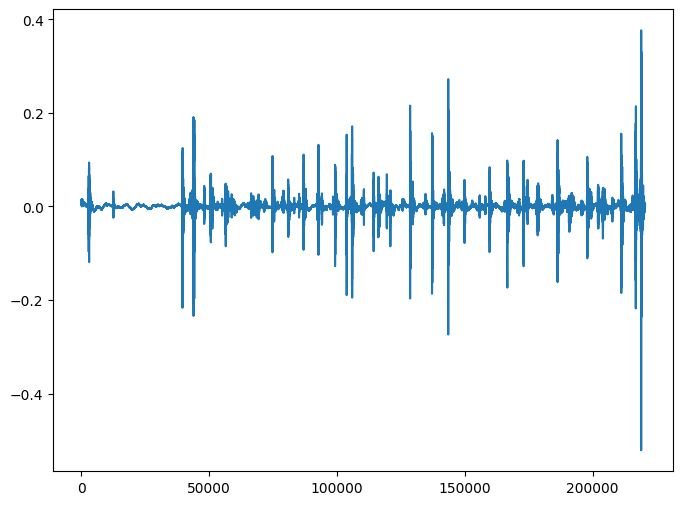

In [ ]:
# 1. Load File
audio_path = './1-137-A-32.wav'
y, sr = librosa.load(audio_path,sr = None)# sr:The original sample rate of the audio file
plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(y, label="Original vector")

In [ ]:
# 2. Signal pre-processing：STFT (Short-Time Fourier Transform)
f, t, Zxx = stft(y, fs=sr, nperseg=512) # nperseg: length of each segment
Zxx_real = np.real(Zxx)  # Use only real part for simplicity
Zxx_real.shape

(257, 863)

In [ ]:
# 3: Initialize sensing matrices
n_atoms = 1024  # Number of atoms
dictionary = np.random.randn(Zxx_real.shape[0], n_atoms) #generates samples from the standard normal distribution (mean = 0, variance = 1)

In [ ]:
# 4: Apply OMP
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=100)
sparse_coeffs = np.zeros((n_atoms, Zxx_real.shape[1]))

for i in range(Zxx_real.shape[1]):  # Process each frame(each line in Zxx_real) separately
    omp.fit(dictionary, Zxx_real[:, i])
    sparse_coeffs[:, i] = omp.coef_

In [ ]:
# 5: Reconstruct Signal from Sparse Representation
Zxx_reconstructed = dictionary @ sparse_coeffs
_, y_reconstructed = istft(Zxx_reconstructed + 1j*np.imag(Zxx), fs=sr, nperseg=512)
y_reconstructed = wiener(y_reconstructed) #Apply Wiener Filtering

In [ ]:
# 6: Compute Evaluation Metrics
def compute_metrics(original, reconstructed):
    min_len = min(len(original), len(reconstructed))
    original = original[:min_len]
    reconstructed = reconstructed[:min_len]# Ensure both signals are the same length

    noise = original - reconstructed
    snr = 10 * np.log10(np.sum(original**2) / np.sum(noise**2))# Signal-to-Noise Ratio (SNR)

    mse = mean_squared_error(original, reconstructed)# Mean Squared Error (MSE)

    pcc, _ = pearsonr(original, reconstructed)# Pearson Correlation Coefficient (PCC)

    return snr, mse, pcc

snr, mse, pcc = compute_metrics(y, y_reconstructed)

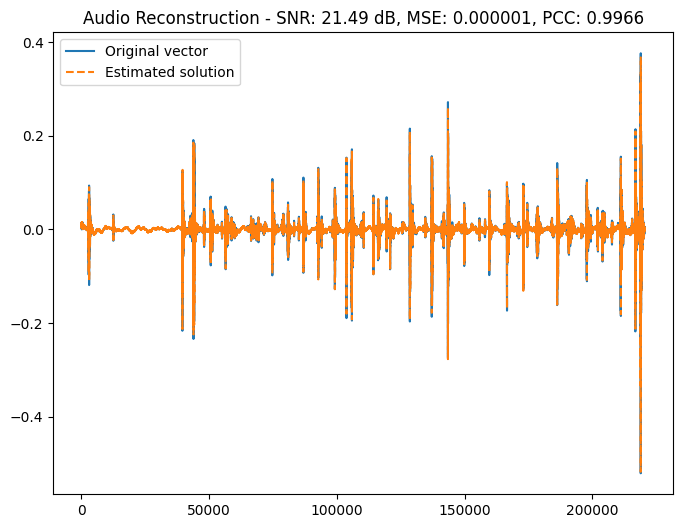

In [ ]:
plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(y, label="Original vector")
plt.plot(y_reconstructed, '--', label="Estimated solution")
plt.legend()
plt.title(f"Audio Reconstruction - SNR: {snr:.2f} dB, MSE: {mse:.6f}, PCC: {pcc:.4f}")
plt.show()

In [ ]:
# 7: Save and Play Processed Audio
sf.write('reconstructed_audio.wav', y_reconstructed, sr)